### Importance sampling chatGPT

In [1]:
import numpy as np
n=5000000

# True probability distribution p(x) (fair die)
p = {x: 1/n for x in range(1, n+1)}

# Biased sampling distribution q(x) (importance sampling)
q = {n: 0.5}  # More likely to sample nr. n
for x in range(1, n):
    q[x] = 0.5/(n-1)  # Less likely to sample other numbers

# Importance weights w(x) = p(x) / q(x)
w = {x: p[x] / q[x] for x in range(1, n+1)}

# Monte Carlo Sampling (Direct from p(x))
def monte_carlo(num_samples=1000):
    samples = np.random.choice(list(p.keys()), size=num_samples, p=list(p.values()))
    estimated_prob = np.mean(samples == n)  # Fraction of 6s in samples
    return estimated_prob

# Importance Sampling (Sampling from q(x) and correcting with weights)
def importance_sampling(num_samples=1000):
    samples = np.random.choice(list(q.keys()), size=num_samples, p=list(q.values()))
    weights = np.array([w[x] for x in samples])  # Apply importance weights
    estimated_prob = np.mean((samples == n) * weights)  # Weighted mean
    return estimated_prob

# Run simulations
num_samples = 100
mc_estimate = monte_carlo(num_samples)
is_estimate = importance_sampling(num_samples)

# Output results
(mc_estimate, is_estimate, 1/n)


(0.0, 1.6399999999999999e-07, 2e-07)

## PINN - harmonic oscillator 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random

**True Function**  
The differential equation governing the damped harmonic oscillator is:

$m \frac{d^2 y}{d t^2} + \mu \frac{d y}{d t} + k y = 0$

**Initial Conditions:**  
- $y(0) = 1$  
- $\frac{dy}{dt}(0) = 0$  

**Parameters:**  
- $m$ = Mass  
- $\mu$ = Damping coefficient  
- $k$ = Spring constant  

---

**Exact Solution:**  
The exact solution to the differential equation is:

$y(t) = e^{-\frac{\mu t}{2 m}} \left[ A \cos(\omega t) + B \sin(\omega t) \right]$

**Where:**  
- $\omega = \sqrt{\frac{k}{m} - \left( \frac{\mu}{2 m} \right)^2}$ is the damped natural frequency.  
- $A = y_0$ (from the initial condition $y(0) = y_0$)  
- $B = \frac{\mu}{2 m \omega}$ (from the initial condition $\frac{dy}{dt}(0) = 0$)  


### Exact sol

-0.7438053717166231


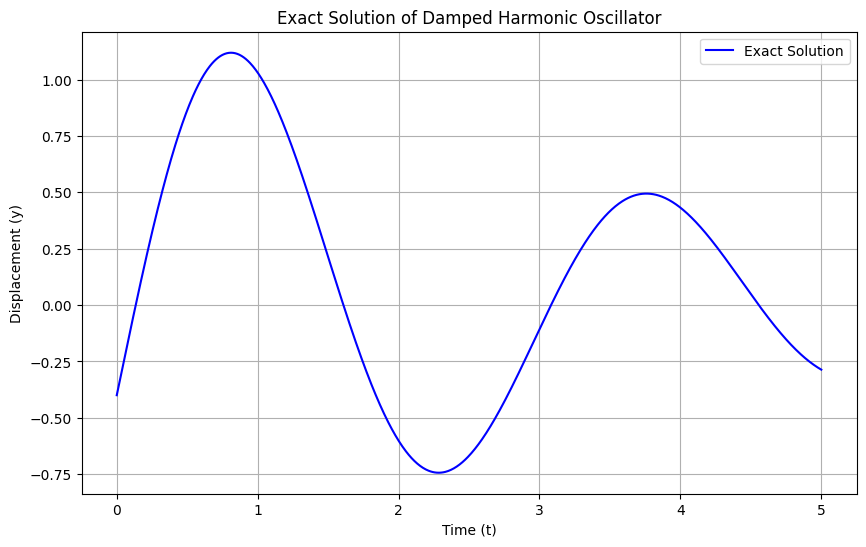

In [99]:
def damped_harmonic_oscillator(t, m=1.0, mu=0.6, k=5.0, y0=-0.4, v0=3.0):
    # Check underdamped condition
    if mu**2 >= 4 * m * k:
        raise ValueError("The system is not underdamped. Ensure that μ^2 < 4 * m * k.")
    
    # Angular frequency
    omega = np.sqrt(k/m - (mu/(2*m)) ** 2)
    
    # Exact solution
    A = y0
    B = (v0 + (mu/(2*m)) * y0) / omega
    y_exact = np.exp(-mu * t / (2 * m)) * (A * np.cos(omega * t) + B * np.sin(omega * t))
    
    return y_exact

def exact_test(m=1.0, mu=0.6, k=5.0, y0=-0.4, v0=3.0):
    # Time range
    t = np.linspace(0, 5, 1000)

    # Compute the exact solution
    y_exact = damped_harmonic_oscillator (t, m, mu, k, y0, v0 )
    print(min(y_exact))

    # Plotting the exact solution
    plt.figure(figsize=(10, 6))
    plt.plot(t, y_exact, label='Exact Solution', color='blue')
    plt.title('Exact Solution of Damped Harmonic Oscillator')
    plt.xlabel('Time (t)')
    plt.ylabel('Displacement (y)')
    plt.grid(True)
    plt.legend()
    plt.show()

exact_test(m= 1.0821)

### MC of exact sol with gaussian params

Estimated Probability of Exceeding Threshold: 0.002408


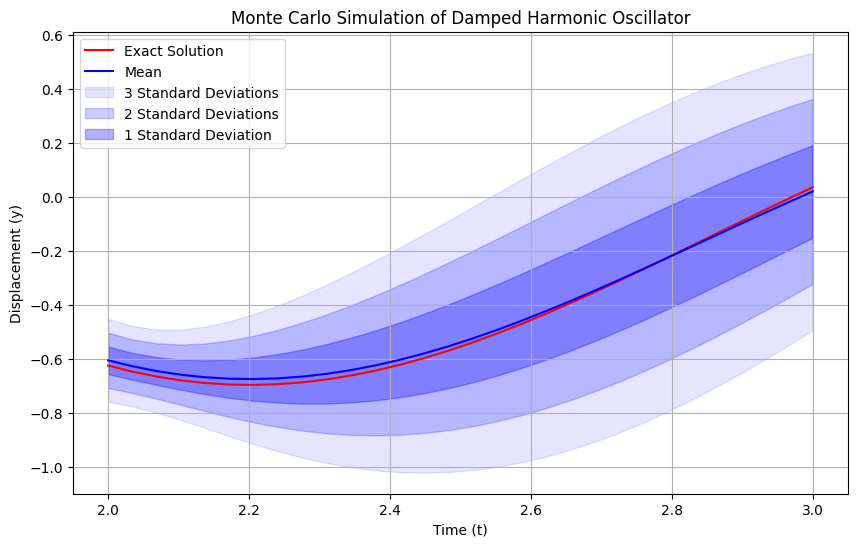

In [97]:
def MC_sim(Num,m=1.0, mu=0.6, k=5.0, y0=-0.4, v0=3.0):

    # Uncertainty in input parameters
    m_samples = np.random.normal(m, 0.1, Num)
    mu_samples = np.random.normal(mu, 0.05, Num)
    k_samples = np.random.normal(k, 0.2, Num)
    y0_samples = np.random.normal(y0, 0.0, Num)

    # Monte Carlo simulation for the damped harmonic oscillator
    y_mc = []
    for i in range(Num):
        y_mc.append(damped_harmonic_oscillator(t, m_samples[i], mu_samples[i], k_samples[i], y0_samples[i], v0))
    
    return y_mc

def plot_MC(y_mc):
    y_exact=damped_harmonic_oscillator(t)

    # probability distribution of the displacement at each time step
    y_mc = np.array(y_mc)
    y_mean = np.mean(y_mc, axis=0)
    y_std = np.std(y_mc, axis=0)

    #plotting the mean and standard deviation of the Monte Carlo simulation
    plt.figure(figsize=(10, 6))
    plt.plot(t, y_exact, label='Exact Solution', color='red')
    plt.plot(t, y_mean, label='Mean', color='blue')
    # 3 Standard Deviations
    plt.fill_between(t, y_mean - 3 * y_std, y_mean + 3 * y_std, color='blue', alpha=0.1, label='3 Standard Deviations')
    # 2 Standard Deviations
    plt.fill_between(t, y_mean - 2 * y_std, y_mean + 2 * y_std, color='blue', alpha=0.2, label='2 Standard Deviations')
    # 1 Standard Deviation
    plt.fill_between(t, y_mean - y_std, y_mean + y_std, color='blue', alpha=0.3, label='1 Standard Deviation')
    plt.title('Monte Carlo Simulation of Damped Harmonic Oscillator')
    plt.xlabel('Time (t)')
    plt.ylabel('Displacement (y)')
    plt.grid(True)
    plt.legend()
    plt.show()

def treshold_MC(y_mc, y_threshold=-1.0):
    y_threshold= np.array(y_threshold)
    # Estimate the probability of exceeding the threshold using Importance Sampling
    prob_exceed = np.mean(np.any(y_mc < y_threshold, axis=1))
    print(f"Estimated Probability of Exceeding Threshold: {prob_exceed}")

    return prob_exceed

Num = 1000000
t = np.linspace(2, 3, 30)
y_mc = MC_sim(Num,m=1.0)
treshold_MC(y_mc, y_threshold=-0.9)
plot_MC(y_mc)


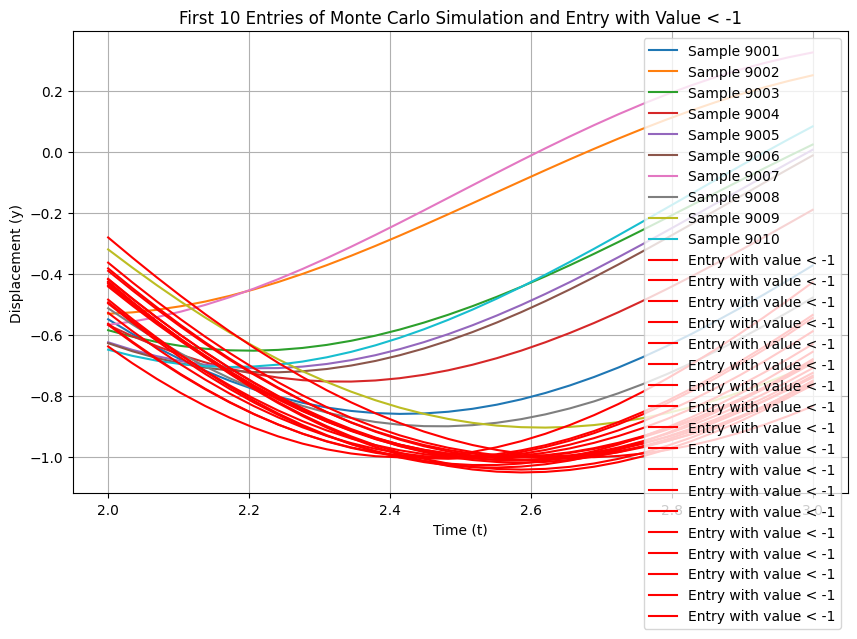

In [5]:
plt.figure(figsize=(10, 6))
for i in range(9000,9010):
    plt.plot(t, y_mc[i], label=f'Sample {i+1}')

# Find an entry that has a value lower than -1
for i in range(Num):
    if np.any(y_mc[i] < -1):
        plt.plot(t, y_mc[i], label=f'Entry with value < -1', color='red')

plt.title('First 10 Entries of Monte Carlo Simulation and Entry with Value < -1')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()

Estimated Probability of Exceeding Threshold of -1.0: 1.05e-05 (10.000.000 samples)
1.11e-05 for second run 

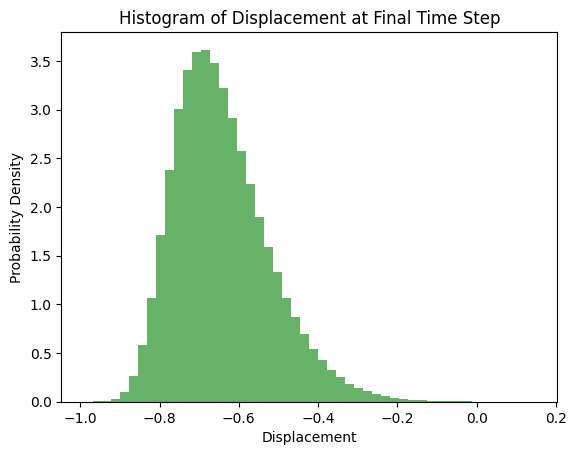

In [6]:
y_mc_array = np.array(y_mc)
plt.hist(y_mc_array[:, 10], bins=50, density=True, alpha=0.6, color='g')
plt.title('Histogram of Displacement at Final Time Step')
plt.xlabel('Displacement')
plt.ylabel('Probability Density')
plt.show()

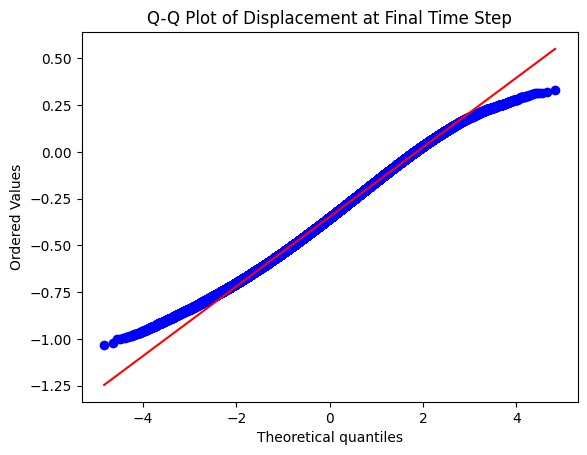

In [7]:
import scipy.stats as stats
stats.probplot(y_mc_array[:, 20], dist="norm", plot=plt)
plt.title('Q-Q Plot of Displacement at Final Time Step')
plt.show()

### PINN functions

In [102]:
# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define the PINN model
class PINN_fixed(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3, dropout_rate=0.05):
        super(PINN_fixed, self).__init__()
        input_dim = 6
        layers = [nn.Linear(input_dim, hidden_size), nn.Tanh()]
        
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout_rate))
        
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, t, m, mu, k, y0, v0):
        N = t.shape[0]
        m_  = m.expand(N, -1)
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, m_, mu_, k_, y0_, v0_], dim=1)
        return self.net(x)


# Compute PDE loss
def pde_loss(model, t, m, mu, k, y0_val, v0_val):
    y = model(t, m, mu, k, y0_val, v0_val)
    y_t = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    y_tt = torch.autograd.grad(y_t, t, grad_outputs=torch.ones_like(y_t), create_graph=True)[0]
    residual = m * y_tt + mu * y_t + k * y
    return torch.mean(residual**2)

# Compute boundary loss
def boundary_loss(model, t0, m, mu, k, y0, v0):
    y_pred = model(t0, m, mu, k, y0, v0)
    y_t = torch.autograd.grad(y_pred, t0, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    return torch.mean((y_pred - y0)**2 + (y_t - v0)**2)

def plot_loss(epoch, losses_dict):
    plt.figure(figsize=(5, 3))
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epoch, loss_values, label=loss_name)
    plt.yscale('log')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Trainer class to manage training process
class Trainer:
    def __init__(self, model, optimizer, epochs=4001):
        self.model = model
        self.optimizer = optimizer
        self.epochs = epochs
        self.losses = {"Residual Loss": [], "Boundary Loss": []}
        self.lambda_bc = 10.0
    
    def train(self, t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0):
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()
            loss_pde = pde_loss(self.model, t_coll, m_val, mu_val, k_val, y0_val, v0_val)
            loss_bc = boundary_loss(self.model, t0, m_val, mu_val, k_val, y0_val, v0_val)
            loss = loss_pde + self.lambda_bc * loss_bc
            loss.backward()
            self.optimizer.step()
            
            self.losses["Residual Loss"].append(loss_pde.item())
            self.losses["Boundary Loss"].append(loss_bc.item())
            
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, PDE loss: {loss_pde.item()}, BC loss: {loss_bc.item()}")
                plot_loss(range(epoch + 1), self.losses)

### PINN solving the PDE with fixed params

$m \frac{d^2 y}{d t^2} + \mu \frac{d y}{d t} + k y = 0$

Epoch 0, PDE loss: 0.33369264006614685, BC loss: 9.01452922821045


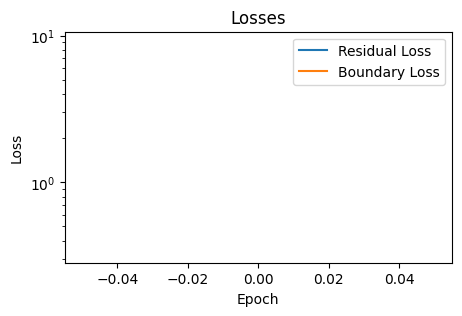

Epoch 1000, PDE loss: 0.07092244178056717, BC loss: 1.1372076187399216e-05


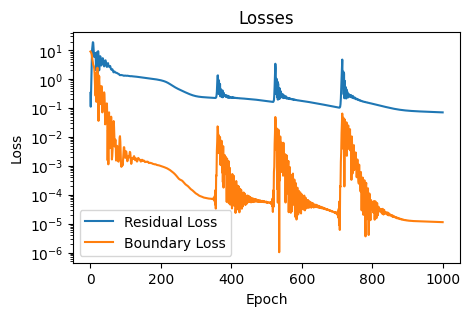

Epoch 2000, PDE loss: 0.029277632012963295, BC loss: 3.8909324757696595e-06


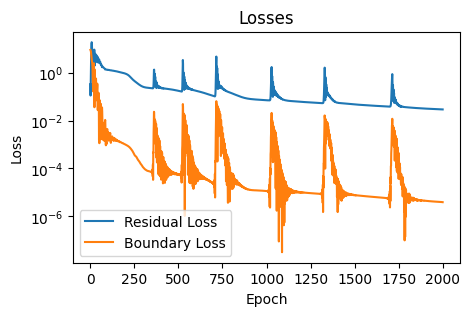

Epoch 3000, PDE loss: 0.012125056236982346, BC loss: 7.512990850955248e-05


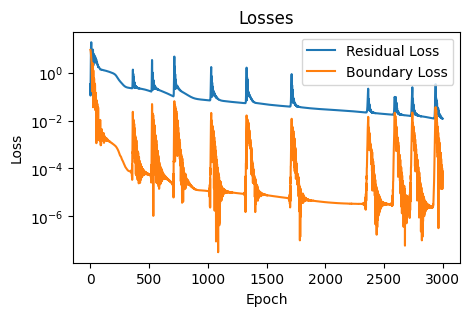

Epoch 4000, PDE loss: 0.026318786665797234, BC loss: 0.002258969470858574


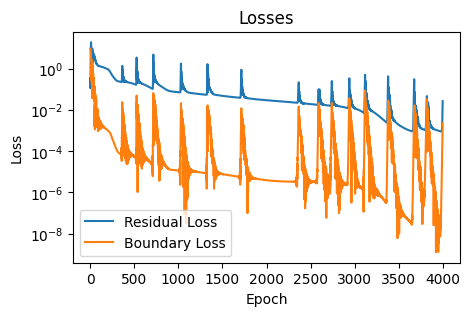

In [103]:
def initialize_fixed_parameters(Num=500):
    t_coll = torch.rand(Num,1)*5
    t_coll.requires_grad_(True)
    
    m, mu, k = 1.0, 0.6, 5.0
    y0, v0 = -0.4, 3.0
    
    m_val  = torch.tensor([[m]], requires_grad=True)
    mu_val = torch.tensor([[mu]], requires_grad=True)
    k_val  = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)
    
    t0 = torch.tensor([0.0]).view(-1,1).requires_grad_(True)
    
    return t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0

# Run training pipeline
set_seed()
t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0 = initialize_fixed_parameters()
fixed_model = PINN_fixed(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(fixed_model.parameters(), lr=0.01)
trainer = Trainer(fixed_model, optimizer)
trainer.train(t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0)

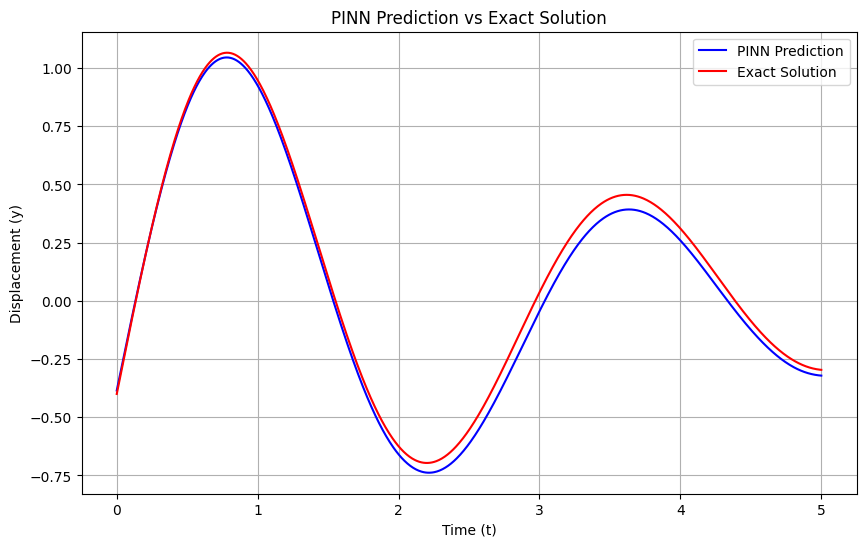

In [104]:
fixed_model.train()

# plot the model prediction
t_test = torch.linspace(0, 5, 1000).view(-1, 1)
y_pred = fixed_model(t_test, m_val, mu_val, k_val, y0_val, v0_val)
y_exact = damped_harmonic_oscillator(t_test)

plt.figure(figsize=(10, 6))
plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), label='PINN Prediction', color='blue')
plt.plot(t_test.detach().numpy(), y_exact, label='Exact Solution', color='red')
plt.title('PINN Prediction vs Exact Solution')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()

### Simple PINN with gaussian mass

Epoch 0, PDE loss: 0.05519729480147362, BC loss: 9.271295547485352


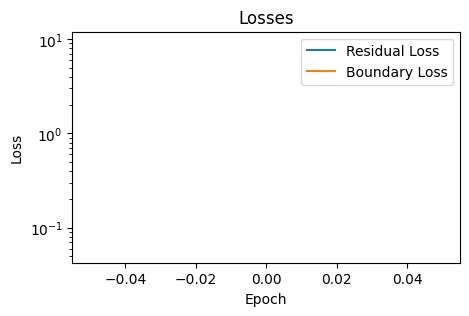

Epoch 1000, PDE loss: 0.26152122020721436, BC loss: 0.0020833145827054977


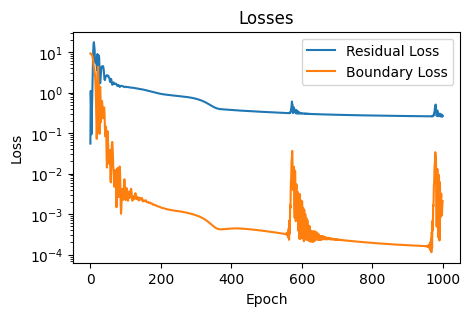

Epoch 2000, PDE loss: 0.04210056737065315, BC loss: 4.328801151132211e-05


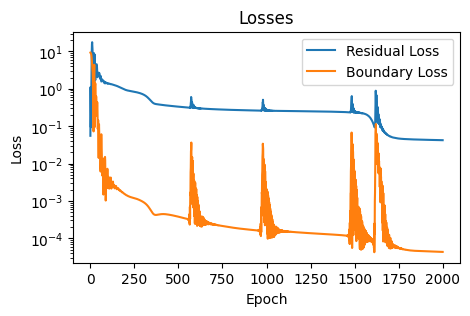

Epoch 3000, PDE loss: 0.034912578761577606, BC loss: 4.1290128137916327e-05


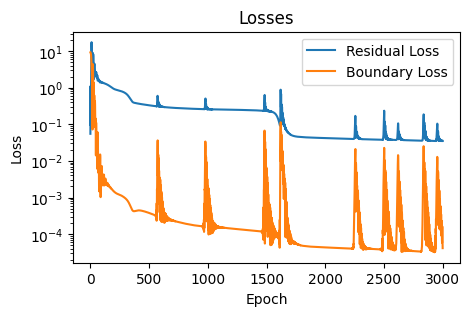

Epoch 4000, PDE loss: 0.02883204072713852, BC loss: 2.7604966817307286e-05


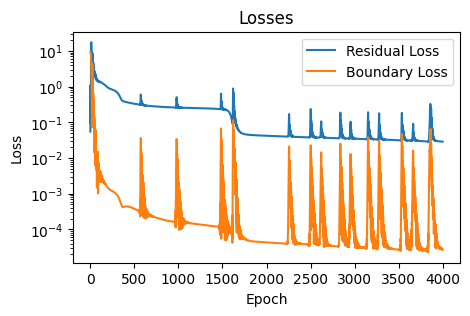

In [11]:
# Define the PINN model
class PINN_gaussian_mass(PINN_fixed):  
    def forward(self, t, m, mu, k, y0, v0):
        N = m.shape[0]
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, m, mu_, k_, y0_, v0_], dim=1)
        return self.net(x)

# Initialize training parameters
def initialize_gaussian_mass():
    N = 500
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = 1.0, 0.1
    m_coll = m_mean + m_std * torch.randn((N, 1)) # Sample from standard normal and scale
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu, k, y0, v0 = 0.6, 5.0, -0.4, 3.0
    # Define parameters as scalars (shape (1, 1))
    mu_val = torch.tensor([[mu]], requires_grad=True)
    k_val = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0

# Run training pipeline
set_seed()
t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0 = initialize_gaussian_mass()
gaussian_mass_model = PINN_gaussian_mass(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(gaussian_mass_model.parameters(), lr=0.01)
trainer = Trainer(gaussian_mass_model, optimizer)
trainer.train(t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0)


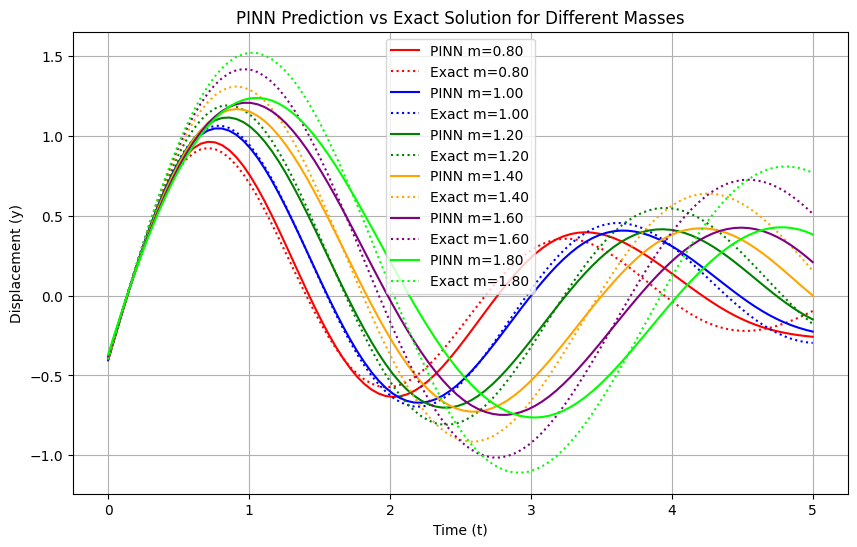

Mass = 0.80, MSE = 0.007194
Mass = 1.00, MSE = 0.001454
Mass = 1.20, MSE = 0.005785
Mass = 1.40, MSE = 0.019214
Mass = 1.60, MSE = 0.037799
Mass = 1.80, MSE = 0.062226

Combined Mean Squared Error over all masses: 0.022279


In [12]:
m_mean, m_std = 1.0, 0.1
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
t_test = torch.linspace(0, 5, 100).view(-1, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime']

plt.figure(figsize=(10, 6))

for idx, m in enumerate(m_values):
    color = colors[idx]
    m_test = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred = gaussian_mass_model(t_test, m_test, mu_val, k_val, y0_val, v0_val)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    
    plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), color=color, label=f'PINN m={m:.2f}')
    plt.plot(t_test.detach().numpy(), y_exact, linestyle='dotted', color=color, label=f'Exact m={m:.2f}')

plt.title('PINN Prediction vs Exact Solution for Different Masses')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()

# Compute and print error metrics for different masses
errors = []
for m in m_values:
    m_test_current = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred_current = gaussian_mass_model(t_test, m_test_current, mu_val, k_val, y0_val, v0_val)
    y_exact_current = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    mse_current = np.mean((y_pred_current.detach().numpy() - y_exact_current)**2)
    errors.append(mse_current)
    print(f"Mass = {m:.2f}, MSE = {mse_current:.6f}")

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all masses: {combined_mse:.6f}")

### Uniform distr. mass

Epoch 0, PDE loss: 0.09658359736204147, BC loss: 9.113851547241211


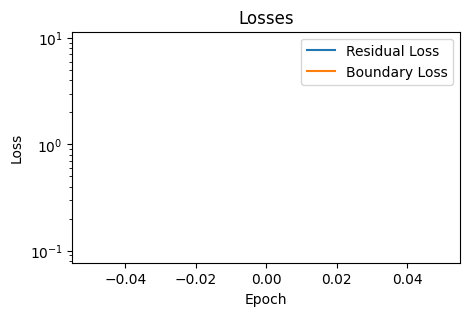

Epoch 1000, PDE loss: 0.1557406634092331, BC loss: 0.0002874687488656491


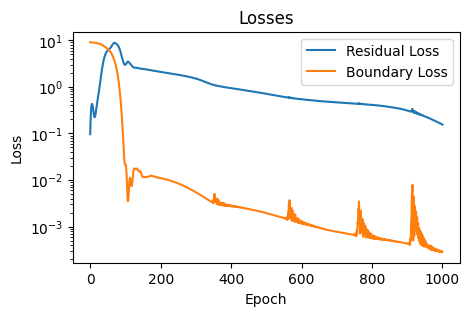

Epoch 2000, PDE loss: 0.03839625418186188, BC loss: 5.239417077973485e-05


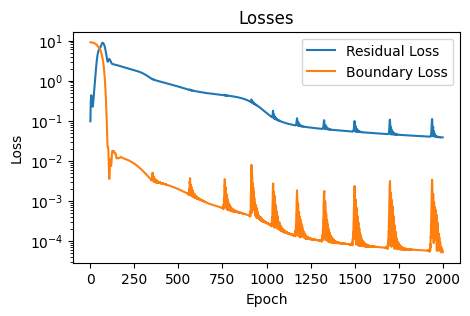

Epoch 3000, PDE loss: 0.018069136887788773, BC loss: 5.4323791118804365e-05


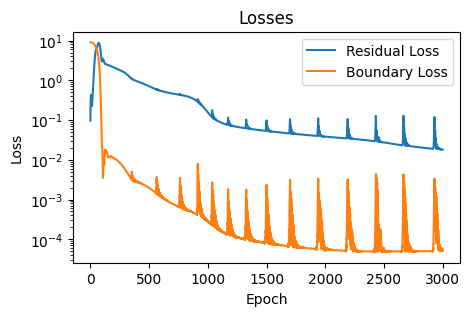

Epoch 4000, PDE loss: 0.010488633997738361, BC loss: 4.829532917938195e-05


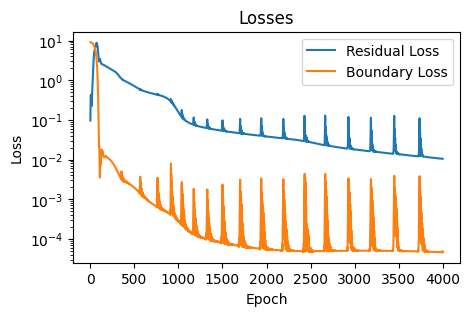

In [13]:
# Initialize training parameters
def initialize_uniform_mass():
    N = 500
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = 1.0, 0.1
    m_coll = torch.FloatTensor(N, 1).uniform_(m_mean - 2 * m_std, m_mean + 8 * m_std)
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu, k, y0, v0 = 0.6, 5.0, -0.4, 3.0
    # Define parameters as scalars (shape (1, 1))
    mu_val = torch.tensor([[mu]], requires_grad=True)
    k_val = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0

# Run training pipeline
set_seed()
t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0 = initialize_uniform_mass()
uniform_mass_model = PINN_gaussian_mass(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(uniform_mass_model.parameters(), lr=0.001)
trainer = Trainer(uniform_mass_model, optimizer)
trainer.train(t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0)

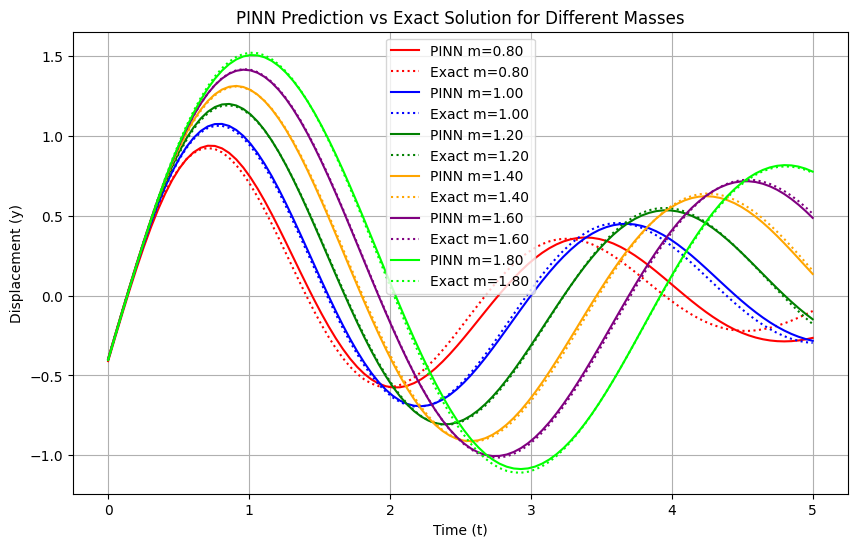

Mass = 0.80, MSE = 0.004623
Mass = 1.00, MSE = 0.000682
Mass = 1.20, MSE = 0.000092
Mass = 1.40, MSE = 0.000222
Mass = 1.60, MSE = 0.000117
Mass = 1.80, MSE = 0.000230

Combined Mean Squared Error over all masses: 0.000995


In [14]:
m_mean, m_std = 1.0, 0.1
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
t_test = torch.linspace(0, 5, 100).view(-1, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime']

plt.figure(figsize=(10, 6))

for idx, m in enumerate(m_values):
    color = colors[idx]
    m_test = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred = uniform_mass_model(t_test, m_test, mu_val, k_val, y0_val, v0_val)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    
    plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), color=color, label=f'PINN m={m:.2f}')
    plt.plot(t_test.detach().numpy(), y_exact, linestyle='dotted', color=color, label=f'Exact m={m:.2f}')

plt.title('PINN Prediction vs Exact Solution for Different Masses')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()

# Compute and print error metrics for different masses
errors = []
for m in m_values:
    m_test_current = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred_current = uniform_mass_model(t_test, m_test_current, mu_val, k_val, y0_val, v0_val)
    y_exact_current = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    mse_current = np.mean((y_pred_current.detach().numpy() - y_exact_current)**2)
    errors.append(mse_current)
    print(f"Mass = {m:.2f}, MSE = {mse_current:.6f}")

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all masses: {combined_mse:.6f}")

### Parameterized PINN with uniform mass 

#### simple - m, mu, k & t, y0, v0

Epoch 0, PDE loss: 0.00015414344670716673, BC loss: 9.15797233581543


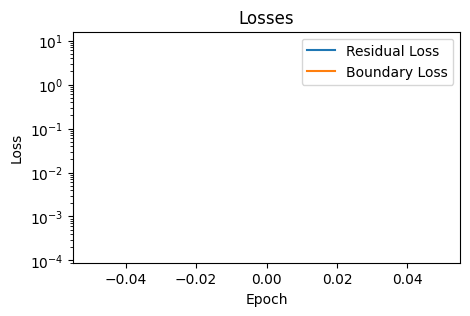

Epoch 1000, PDE loss: 0.4630730450153351, BC loss: 0.000510930665768683


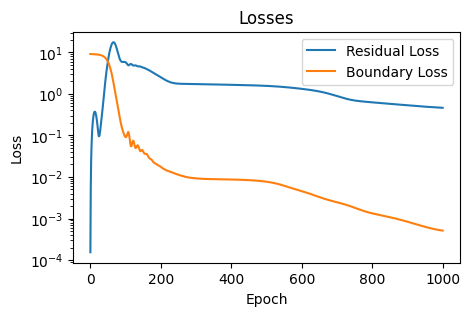

Epoch 2000, PDE loss: 0.08500605076551437, BC loss: 6.273527833400294e-05


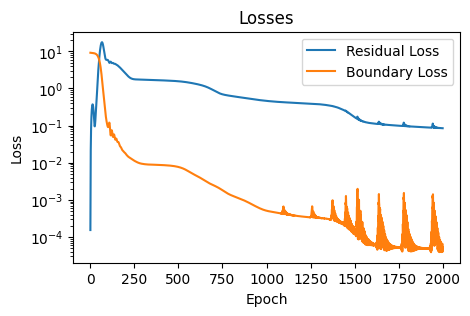

Epoch 3000, PDE loss: 0.05517992377281189, BC loss: 3.409806959098205e-05


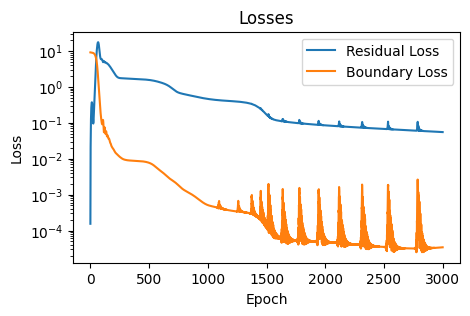

Epoch 4000, PDE loss: 0.031958166509866714, BC loss: 6.561363989021629e-05


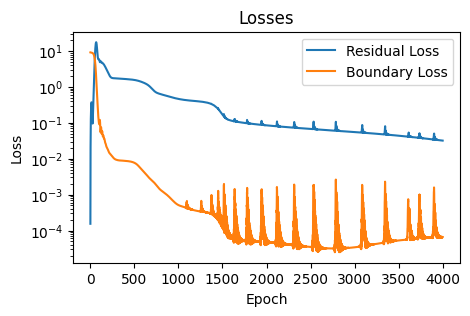

In [15]:
# Define separate encoders
class ParameterEncoder(nn.Module):
    def __init__(self, hidden_size):
        super(ParameterEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh()
        )

    def forward(self, m, mu, k):
        N = m.shape[0]
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)
        x = torch.cat([m, mu_, k_], dim=1)
        return self.net(x)

class CoordinateEncoder(nn.Module):
    def __init__(self, hidden_size):
        super(CoordinateEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh()
        )

    def forward(self, t, y0, v0):
        N = t.shape[0]
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, y0_, v0_], dim=1)
        return self.net(x)

# Define the main manifold network
class PINN_P2INN(nn.Module):
    def __init__(self, hidden_size=30, hidden_layers=3):
        super(PINN_P2INN, self).__init__()

        self.encoder_p = ParameterEncoder(hidden_size)
        self.encoder_c = CoordinateEncoder(hidden_size)

        layers = [nn.Linear(2 * hidden_size, hidden_size), nn.Tanh()]
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, t, m, mu, k, y0, v0):
        h_param = self.encoder_p(m, mu, k)
        h_coord = self.encoder_c(t, y0, v0)
        h_concat = torch.cat([h_param, h_coord], dim=1)
        return self.net(h_concat)

# Run training pipeline
torch.manual_seed(42)
t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0 = initialize_uniform_mass()

P2INN_uniform_mass_model = PINN_P2INN(hidden_size=15, hidden_layers=2)
optimizer = optim.Adam(P2INN_uniform_mass_model.parameters(), lr=0.001)
trainer = Trainer(P2INN_uniform_mass_model, optimizer, epochs=4001)
trainer.train(t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0)


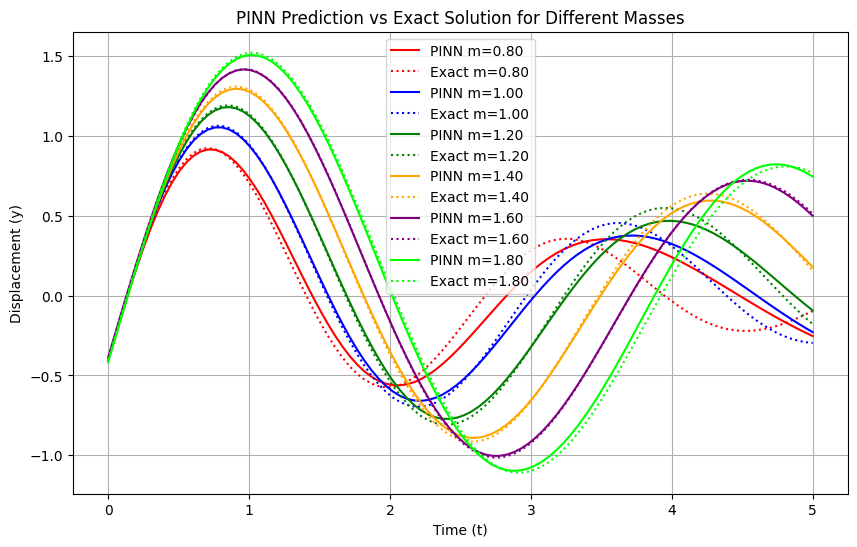

Mass = 0.80, MSE = 0.016388
Mass = 1.00, MSE = 0.004403
Mass = 1.20, MSE = 0.001566
Mass = 1.40, MSE = 0.000487
Mass = 1.60, MSE = 0.000043
Mass = 1.80, MSE = 0.001387

Combined Mean Squared Error over all masses: 0.004046


In [16]:
m_mean, m_std = 1.0, 0.1
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
t_test = torch.linspace(0, 5, 100).view(-1, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime']

plt.figure(figsize=(10, 6))

for idx, m in enumerate(m_values):
    color = colors[idx]
    m_test = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred = P2INN_uniform_mass_model(t_test, m_test, mu_val, k_val, y0_val, v0_val)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    
    plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), color=color, label=f'PINN m={m:.2f}')
    plt.plot(t_test.detach().numpy(), y_exact, linestyle='dotted', color=color, label=f'Exact m={m:.2f}')

plt.title('PINN Prediction vs Exact Solution for Different Masses')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()

# Compute and print error metrics for different masses
errors = []
for m in m_values:
    m_test_current = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred_current = P2INN_uniform_mass_model(t_test, m_test_current, mu_val, k_val, y0_val, v0_val)
    y_exact_current = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    mse_current = np.mean((y_pred_current.detach().numpy() - y_exact_current)**2)
    errors.append(mse_current)
    print(f"Mass = {m:.2f}, MSE = {mse_current:.6f}")

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all masses: {combined_mse:.6f}")

#### simple -  m, mu, k, y0, v0, t & t

Epoch 0, PDE loss: 1.3737436532974243, BC loss: 9.068599700927734


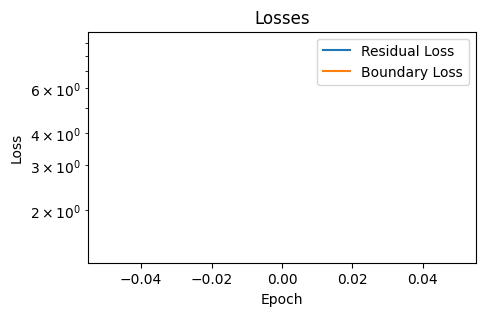

Epoch 1000, PDE loss: 0.42954474687576294, BC loss: 0.0005059195100329816


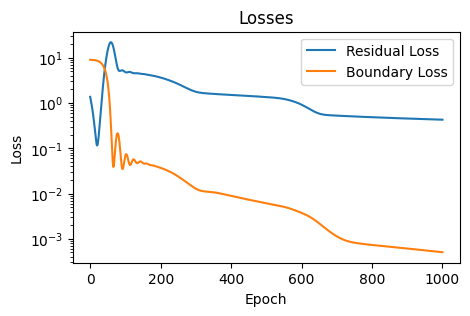

Epoch 2000, PDE loss: 0.025901416316628456, BC loss: 8.194750262191519e-05


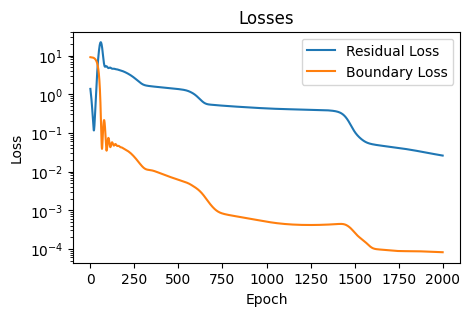

In [66]:
# Define separate encoders
class ParameterEncoder(nn.Module):
    def __init__(self, hidden_size):
        super(ParameterEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(6, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh()
        )

    def forward(self, m, mu, k, y0, v0,t):
        N = m.shape[0]
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([m, mu_, k_,y0_,v0_,t], dim=1)
        return self.net(x)

class CoordinateEncoder(nn.Module):
    def __init__(self, hidden_size):
        super(CoordinateEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh()
        )

    def forward(self, t):
        N = t.shape[0]

        x = torch.cat([t], dim=1)
        return self.net(x)

# Define the main manifold network
class PINN_P2INN(nn.Module):
    def __init__(self, hidden_size=30, hidden_layers=3):
        super(PINN_P2INN, self).__init__()

        self.encoder_p = ParameterEncoder(hidden_size)
        self.encoder_c = CoordinateEncoder(hidden_size)

        layers = [nn.Linear(2 * hidden_size, hidden_size), nn.Tanh()]
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, t, m, mu, k, y0, v0):
        h_param = self.encoder_p(m, mu, k, y0, v0,t)
        h_coord = self.encoder_c(t)
        h_concat = torch.cat([h_param, h_coord], dim=1)
        return self.net(h_concat)

# Run training pipeline
torch.manual_seed(42)
t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0 = initialize_uniform_mass()

P2INN_uniform_mass_model = PINN_P2INN(hidden_size=15, hidden_layers=2)
optimizer = optim.Adam(P2INN_uniform_mass_model.parameters(), lr=0.001)
trainer = Trainer(P2INN_uniform_mass_model, optimizer, epochs=2501)
trainer.train(t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0)


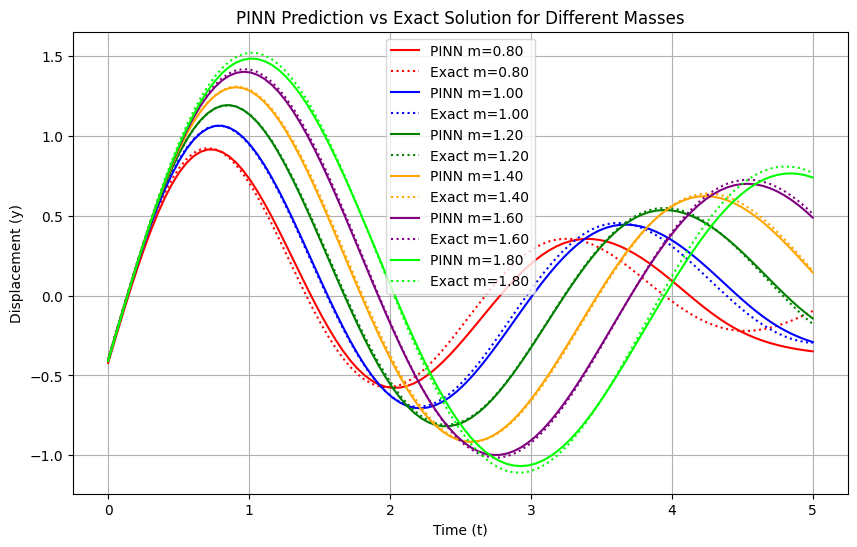

Mass = 0.80, MSE = 0.006376
Mass = 1.00, MSE = 0.000929
Mass = 1.20, MSE = 0.000126
Mass = 1.40, MSE = 0.000181
Mass = 1.60, MSE = 0.000233
Mass = 1.80, MSE = 0.001142

Combined Mean Squared Error over all masses: 0.001498


In [67]:
m_mean, m_std = 1.0, 0.1
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
t_test = torch.linspace(0, 5, 100).view(-1, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime']

plt.figure(figsize=(10, 6))

for idx, m in enumerate(m_values):
    color = colors[idx]
    m_test = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred = P2INN_uniform_mass_model(t_test, m_test, mu_val, k_val, y0_val, v0_val)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    
    plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), color=color, label=f'PINN m={m:.2f}')
    plt.plot(t_test.detach().numpy(), y_exact, linestyle='dotted', color=color, label=f'Exact m={m:.2f}')

plt.title('PINN Prediction vs Exact Solution for Different Masses')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()

# Compute and print error metrics for different masses
errors = []
for m in m_values:
    m_test_current = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred_current = P2INN_uniform_mass_model(t_test, m_test_current, mu_val, k_val, y0_val, v0_val)
    y_exact_current = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    mse_current = np.mean((y_pred_current.detach().numpy() - y_exact_current)**2)
    errors.append(mse_current)
    print(f"Mass = {m:.2f}, MSE = {mse_current:.6f}")

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all masses: {combined_mse:.6f}")

#### Full P2INN article - m, mu, k & t, y0, v0

Epoch 0, PDE loss: 0.06207175925374031, BC loss: 9.126977920532227


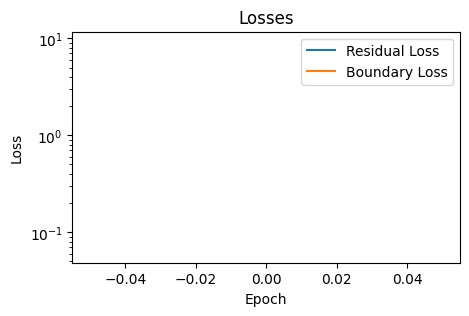

Epoch 1000, PDE loss: 0.036448102444410324, BC loss: 0.0008547618635930121


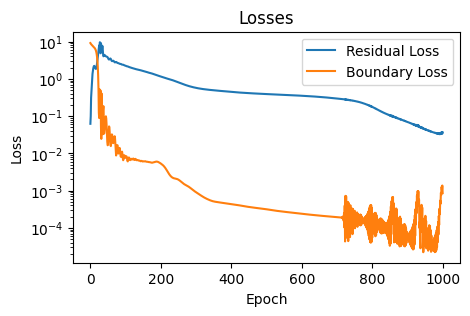

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim

class ParameterEncoder(nn.Module):
    def __init__(self):
        super(ParameterEncoder, self).__init__()
        self.layer1 = nn.Linear(3, 150)
        self.layer2 = nn.Linear(150, 150)
        self.layer3 = nn.Linear(150, 150)
        self.layer4 = nn.Linear(150, 50)
        self.tanh = nn.Tanh()

    def forward(self, m, mu, k):
        N = m.shape[0]
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)

        x = torch.cat([m, mu_, k_], dim=1)
        x = self.tanh(self.layer1(x))
        x = self.tanh(self.layer2(x))
        x = self.tanh(self.layer3(x))
        x = self.tanh(self.layer4(x))
        return x

class CoordinateEncoder(nn.Module):
    def __init__(self):
        super(CoordinateEncoder, self).__init__()
        self.layer1 = nn.Linear(3, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 50)
        self.tanh = nn.Tanh()

    def forward(self, t, y0, v0):
        N = t.shape[0]
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)

        x = torch.cat([t, y0_, v0_], dim=1)
        x = self.tanh(self.layer1(x))
        x = self.tanh(self.layer2(x))
        x = self.tanh(self.layer3(x))
        return x

class PINN_full_P2INN(nn.Module):
    def __init__(self):
        super(PINN_full_P2INN, self).__init__()
        
        self.encoder_p = ParameterEncoder()
        self.encoder_c = CoordinateEncoder()

        self.tanh = nn.Tanh()
        self.relu = nn.ReLU(inplace=True)

        self.dec_layer1 = nn.Linear(100, 50)
        self.dec_layer2 = nn.Linear(50, 50)
        self.dec_layer3 = nn.Linear(50, 50)
        self.dec_layer4 = nn.Linear(50, 50)
        self.dec_layer5 = nn.Linear(50, 50)
        self.dec_layer6 = nn.Linear(50, 50)
        self.last_layer = nn.Linear(50, 1)

        self.modvec = nn.Linear(6, 50)  # 6 inputs: (m, mu, k, t, y0, v0)

    def forward(self, t, m, mu, k, y0, v0):
        h_param = self.encoder_p(m, mu, k)
        h_coord = self.encoder_c(t, y0, v0)

        z_vector = torch.cat([h_param, h_coord], dim=1)

        dec_emb1 = self.tanh(self.dec_layer1(z_vector))
        dec_emb2 = self.tanh(self.dec_layer2(dec_emb1))
        dec_emb3 = self.tanh(self.dec_layer3(dec_emb2) + dec_emb1)
        dec_emb4 = self.tanh(self.dec_layer4(dec_emb3) + dec_emb2)
        dec_emb5 = self.tanh(self.dec_layer5(dec_emb4) + dec_emb3)
        
        N = t.shape[0]
        mu_expanded = mu.expand(N, -1)
        k_expanded = k.expand(N, -1)
        y0_expanded = y0.expand(N, -1)
        v0_expanded = v0.expand(N, -1)
        input_vector = torch.cat([m, mu_expanded, k_expanded, t, y0_expanded, v0_expanded], dim=1)
        hyper_shift = self.modvec(input_vector)

        dec_emb6 = self.tanh(self.dec_layer6(dec_emb5) + dec_emb4 + hyper_shift)
        pred = self.last_layer(dec_emb6)

        return pred

# Run training pipeline
torch.manual_seed(42)
t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0 = initialize_uniform_mass()

P2INN_full_uniform_mass_model = PINN_full_P2INN()
optimizer = optim.Adam(P2INN_full_uniform_mass_model.parameters(), lr=0.001)
trainer = Trainer(P2INN_full_uniform_mass_model, optimizer, epochs=1001)
trainer.train(t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0)


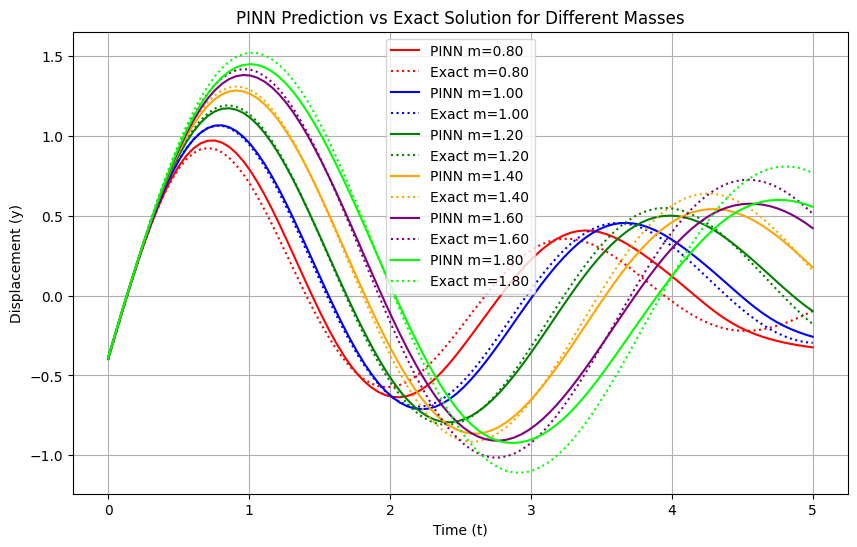

Mass = 0.80, MSE = 0.008918
Mass = 1.00, MSE = 0.001462
Mass = 1.20, MSE = 0.001156
Mass = 1.40, MSE = 0.002595
Mass = 1.60, MSE = 0.006122
Mass = 1.80, MSE = 0.013343

Combined Mean Squared Error over all masses: 0.005599


In [69]:
m_mean, m_std = 1.0, 0.1
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
t_test = torch.linspace(0, 5, 100).view(-1, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime']

plt.figure(figsize=(10, 6))

for idx, m in enumerate(m_values):
    color = colors[idx]
    m_test = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred = P2INN_full_uniform_mass_model(t_test, m_test, mu_val, k_val, y0_val, v0_val)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    
    plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), color=color, label=f'PINN m={m:.2f}')
    plt.plot(t_test.detach().numpy(), y_exact, linestyle='dotted', color=color, label=f'Exact m={m:.2f}')

plt.title('PINN Prediction vs Exact Solution for Different Masses')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()

# Compute and print error metrics for different masses
errors = []
for m in m_values:
    m_test_current = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred_current = P2INN_full_uniform_mass_model(t_test, m_test_current, mu_val, k_val, y0_val, v0_val)
    y_exact_current = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    mse_current = np.mean((y_pred_current.detach().numpy() - y_exact_current)**2)
    errors.append(mse_current)
    print(f"Mass = {m:.2f}, MSE = {mse_current:.6f}")

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all masses: {combined_mse:.6f}")

#### full simplified P2INN - m, mu, k & t, y0, v0

Epoch 0, PDE loss: 0.00030853343196213245, BC loss: 9.176937103271484


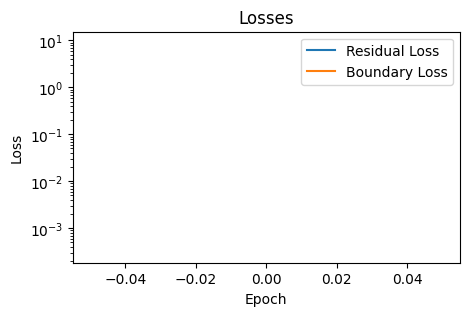

Epoch 1000, PDE loss: 0.03245498985052109, BC loss: 6.639701314270496e-05


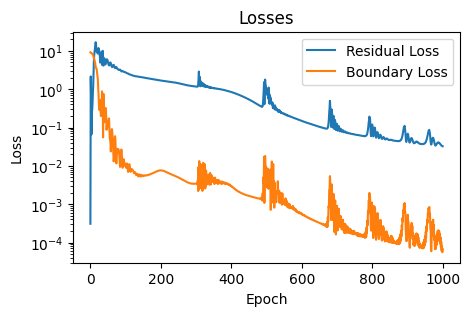

In [70]:
import torch
import torch.nn as nn

class ParameterEncoder(nn.Module):
    def __init__(self):
        super(ParameterEncoder, self).__init__()
        self.layer1 = nn.Linear(3, 150)
        self.layer2 = nn.Linear(150, 150)
        self.layer3 = nn.Linear(150, 150)
        self.layer4 = nn.Linear(150, 50)
        self.tanh = nn.Tanh()

    def forward(self, m, mu, k):
        N = m.shape[0]
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)
        x = torch.cat([m, mu_, k_], dim=1)
        x = self.tanh(self.layer1(x))
        x = self.tanh(self.layer2(x))
        x = self.tanh(self.layer3(x))
        x = self.tanh(self.layer4(x))
        return x

class CoordinateEncoder(nn.Module):
    def __init__(self):
        super(CoordinateEncoder, self).__init__()
        self.layer1 = nn.Linear(3, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 50)
        self.tanh = nn.Tanh()

    def forward(self, t, y0, v0):
        N = t.shape[0]
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, y0_, v0_], dim=1)
        x = self.tanh(self.layer1(x))
        x = self.tanh(self.layer2(x))
        x = self.tanh(self.layer3(x))
        return x

class PINN_P2INN_NoMod(nn.Module):
    def __init__(self):
        super(PINN_P2INN_NoMod, self).__init__()
        
        self.encoder_p = ParameterEncoder()
        self.encoder_c = CoordinateEncoder()

        self.tanh = nn.Tanh()
        self.relu = nn.ReLU(inplace=True)

        self.dec_layer1 = nn.Linear(100, 50)
        self.dec_layer2 = nn.Linear(50, 50)
        self.dec_layer3 = nn.Linear(50, 50)
        self.dec_layer4 = nn.Linear(50, 50)
        self.dec_layer5 = nn.Linear(50, 50)
        self.dec_layer6 = nn.Linear(50, 50)
        self.last_layer = nn.Linear(50, 1)

    def forward(self, t, m, mu, k, y0, v0):
        h_param = self.encoder_p(m, mu, k)
        h_coord = self.encoder_c(t, y0, v0)
        z_vector = torch.cat([h_param, h_coord], dim=1)

        dec_emb1 = self.tanh(self.dec_layer1(z_vector))
        dec_emb2 = self.tanh(self.dec_layer2(dec_emb1))
        dec_emb3 = self.tanh(self.dec_layer3(dec_emb2) + dec_emb1)
        dec_emb4 = self.tanh(self.dec_layer4(dec_emb3) + dec_emb2)
        dec_emb5 = self.tanh(self.dec_layer5(dec_emb4) + dec_emb3)
        
        # Removed modvec: directly compute dec_emb6 without extra hyper-shift.
        dec_emb6 = self.tanh(self.dec_layer6(dec_emb5) + dec_emb4)
        pred = self.last_layer(dec_emb6)

        return pred

# Run training pipeline
torch.manual_seed(42)
t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0 = initialize_uniform_mass()

P2INN_full_uniform_mass_model = PINN_P2INN_NoMod()
optimizer = optim.Adam(P2INN_full_uniform_mass_model.parameters(), lr=0.001)
trainer = Trainer(P2INN_full_uniform_mass_model, optimizer, epochs=1001)
trainer.train(t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0)


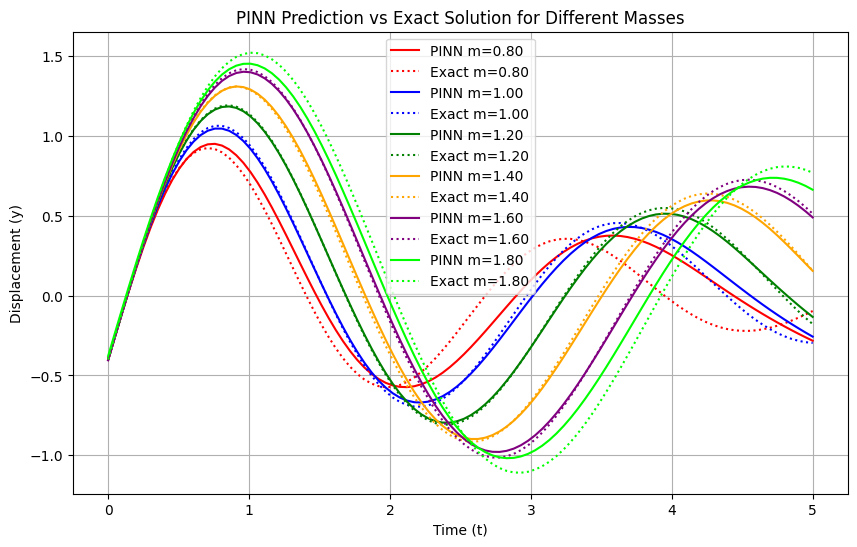

Mass = 0.80, MSE = 0.021808
Mass = 1.00, MSE = 0.002633
Mass = 1.20, MSE = 0.000302
Mass = 1.40, MSE = 0.000745
Mass = 1.60, MSE = 0.000634
Mass = 1.80, MSE = 0.008211

Combined Mean Squared Error over all masses: 0.005722


In [71]:
m_mean, m_std = 1.0, 0.1
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
t_test = torch.linspace(0, 5, 100).view(-1, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime']

plt.figure(figsize=(10, 6))

for idx, m in enumerate(m_values):
    color = colors[idx]
    m_test = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred = P2INN_full_uniform_mass_model(t_test, m_test, mu_val, k_val, y0_val, v0_val)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    
    plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), color=color, label=f'PINN m={m:.2f}')
    plt.plot(t_test.detach().numpy(), y_exact, linestyle='dotted', color=color, label=f'Exact m={m:.2f}')

plt.title('PINN Prediction vs Exact Solution for Different Masses')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()

# Compute and print error metrics for different masses
errors = []
for m in m_values:
    m_test_current = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred_current = P2INN_full_uniform_mass_model(t_test, m_test_current, mu_val, k_val, y0_val, v0_val)
    y_exact_current = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    mse_current = np.mean((y_pred_current.detach().numpy() - y_exact_current)**2)
    errors.append(mse_current)
    print(f"Mass = {m:.2f}, MSE = {mse_current:.6f}")

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all masses: {combined_mse:.6f}")

## Mass, damping coeff, spring constant and y0, v0 as variable 

### Standard PINN 

Epoch 0, PDE loss: 1.3550829887390137, BC loss: 13.210221290588379


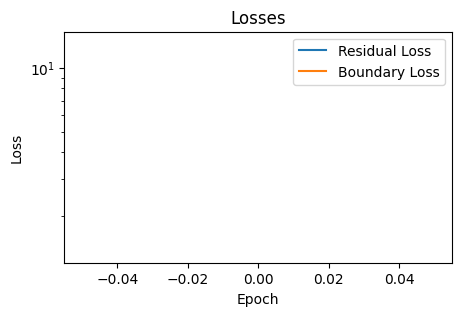

Epoch 1000, PDE loss: 0.5575544238090515, BC loss: 0.005882174242287874


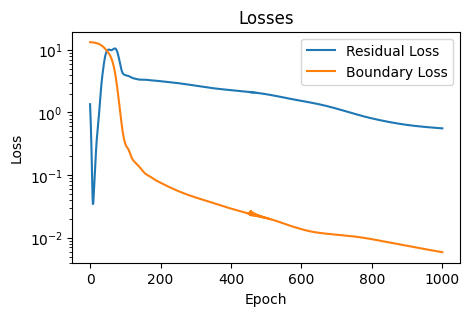

Epoch 2000, PDE loss: 0.2287512570619583, BC loss: 0.002093314426019788


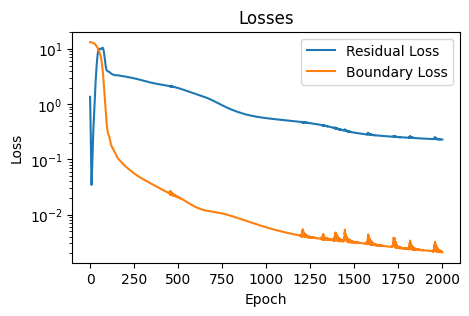

Epoch 3000, PDE loss: 0.17818395793437958, BC loss: 0.0014119806000962853


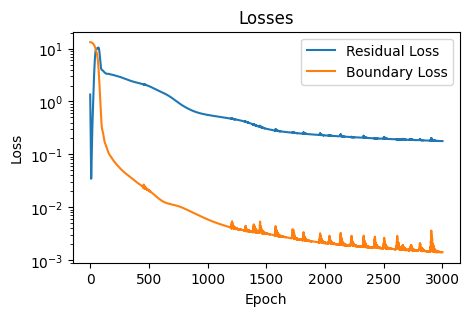

Epoch 4000, PDE loss: 0.1479162722826004, BC loss: 0.0010801119497045875


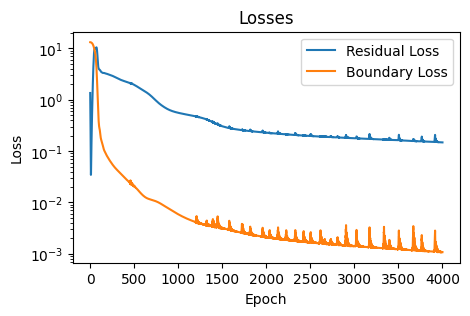

Epoch 5000, PDE loss: 0.11717116087675095, BC loss: 0.0009034040849655867


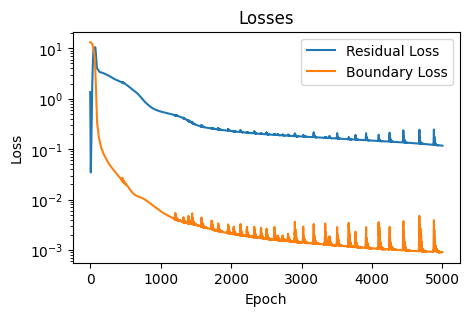

Epoch 6000, PDE loss: 0.08365574479103088, BC loss: 0.0007985683623701334


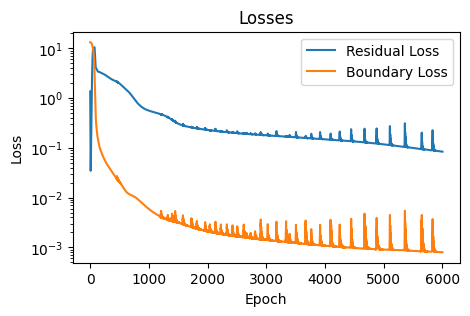

Epoch 7000, PDE loss: 0.05798261612653732, BC loss: 0.0007259330595843494


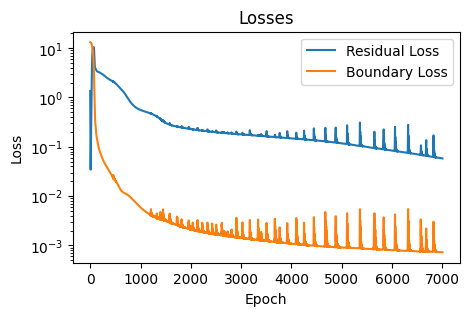

Epoch 8000, PDE loss: 0.042389579117298126, BC loss: 0.000643570558167994


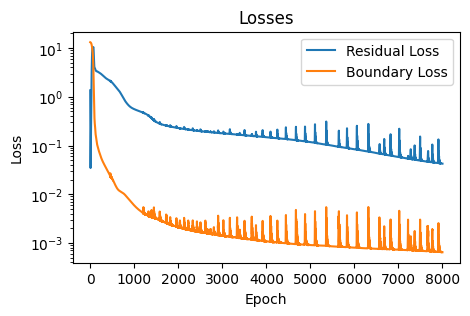

Epoch 9000, PDE loss: 0.03397999703884125, BC loss: 0.0005632839165627956


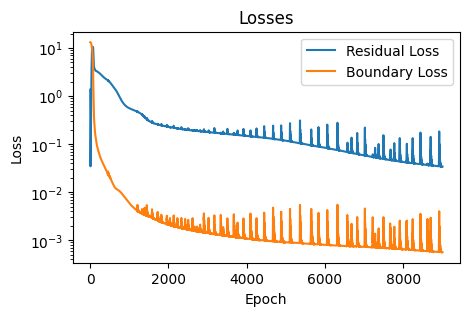

Epoch 10000, PDE loss: 0.027994323521852493, BC loss: 0.0005120961577631533


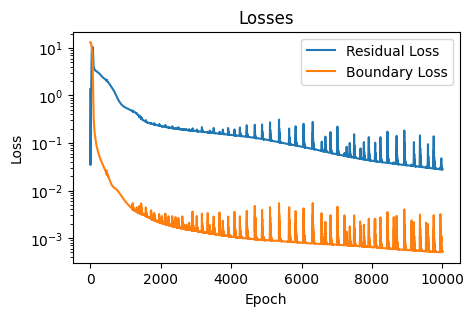

Epoch 11000, PDE loss: 0.023022526875138283, BC loss: 0.0004524645919445902


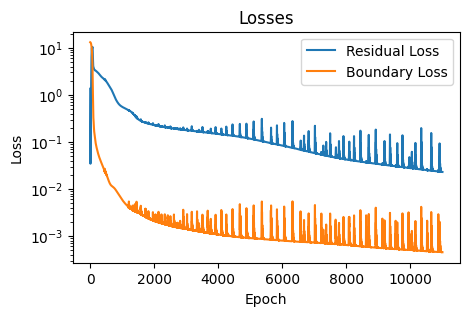

Epoch 12000, PDE loss: 0.01944369077682495, BC loss: 0.0004091560549568385


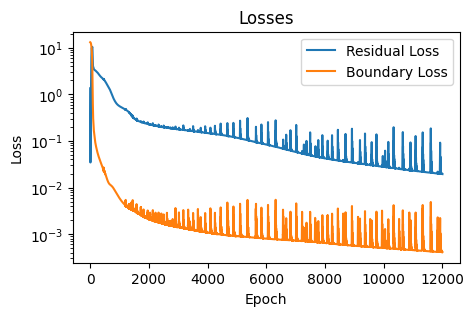

Epoch 13000, PDE loss: 0.01675758883357048, BC loss: 0.0003742487169802189


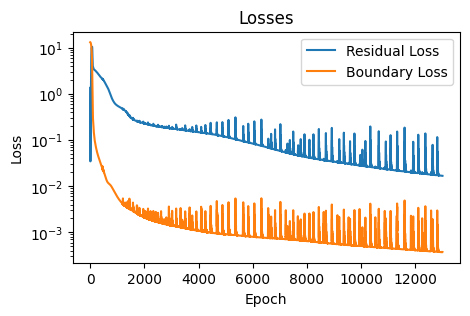

Epoch 14000, PDE loss: 0.014898290857672691, BC loss: 0.00034507791860960424


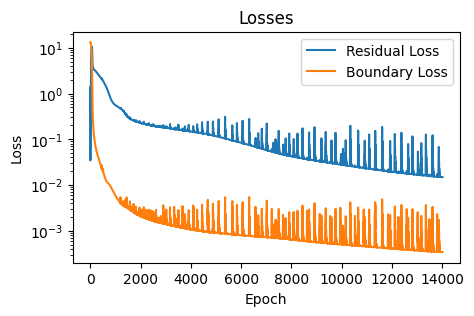

Epoch 15000, PDE loss: 0.01309271901845932, BC loss: 0.0003157681494485587


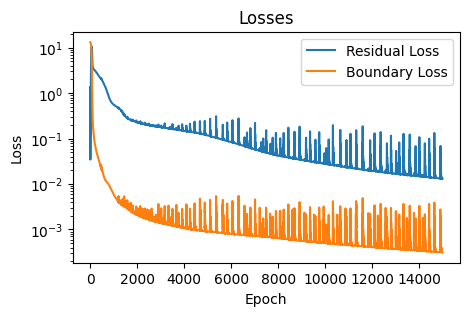

Epoch 16000, PDE loss: 0.011844243854284286, BC loss: 0.0002923176798503846


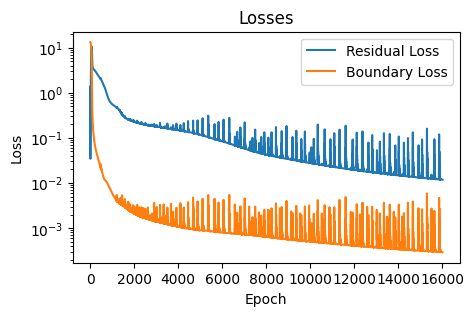

Epoch 17000, PDE loss: 0.01082844752818346, BC loss: 0.0002759924391284585


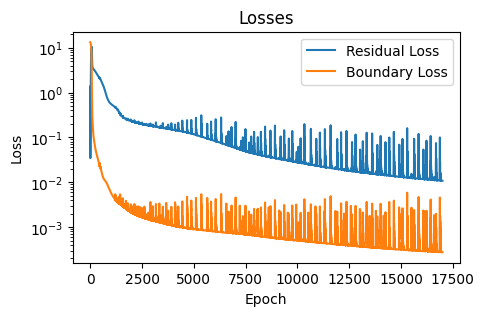

Epoch 18000, PDE loss: 0.00999988242983818, BC loss: 0.0002618160215206444


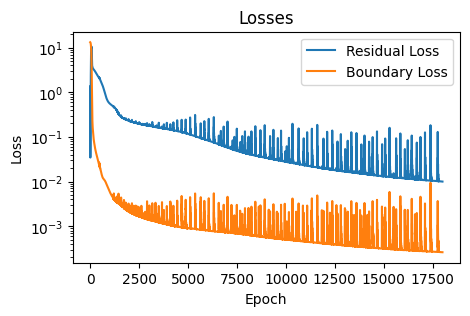

Epoch 19000, PDE loss: 0.009344236925244331, BC loss: 0.00025204019038937986


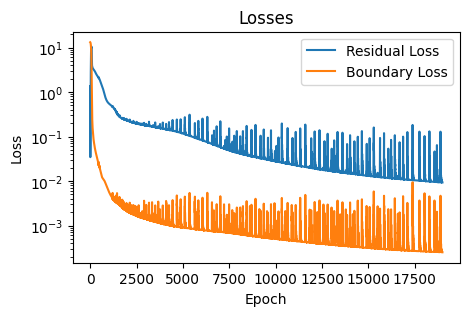

Epoch 20000, PDE loss: 0.00867479294538498, BC loss: 0.00024363308330066502


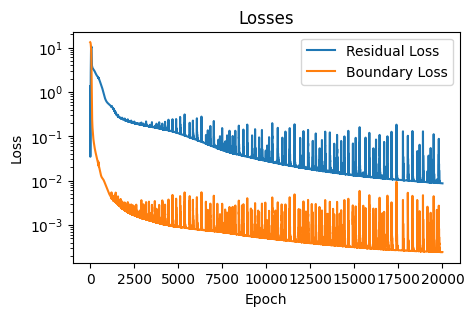

In [95]:
# Define the PINN model
class PINN_all(PINN_fixed):  
    def forward(self, t, m, mu, k, y0, v0):
        x = torch.cat([t, m, mu, k, y0, v0], dim=1)
        return self.net(x)

# Initialize training parameters
def initialize_uniform_all():
    N = 500
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = 1.0, 0.1
    mu_mean, mu_std = 0.6, 0.1
    k_mean, k_std = 5.0, 0.5
    y0_mean, y0_std = -0.4, 0.1
    v0_mean, v0_std = 3.0, 0.5
    m_coll = torch.FloatTensor(N, 1).uniform_(m_mean - 2 * m_std, m_mean + 4 * m_std)
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu_coll = torch.FloatTensor(N, 1).uniform_(mu_mean - 2 * mu_std, mu_mean + 4 * mu_std)
    mu_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    k_coll = torch.FloatTensor(N, 1).uniform_(k_mean - 2 * k_std, k_mean + 4 * k_std)
    k_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    y0_coll = torch.FloatTensor(N, 1).uniform_(y0_mean - 2 * y0_std, y0_mean + 4 * y0_std)
    y0_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    v0_coll = torch.FloatTensor(N, 1).uniform_(v0_mean - 2 * v0_std, v0_mean + 4 * v0_std)
    v0_coll.requires_grad_(True) # Set requires_grad to True for backpropagation

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_coll, k_coll, y0_coll, v0_coll, t0

# Run training pipeline
torch.manual_seed(42)
t_coll, m_coll, mu_coll, k_coll, y0_coll, v0_coll, t0 = initialize_uniform_all()
uniform_all_model = PINN_all(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(uniform_all_model.parameters(), lr=0.001)
trainer = Trainer(uniform_all_model, optimizer,epochs=20001)
trainer.train(t_coll, m_coll, mu_coll, k_coll, y0_coll, v0_coll, t0)

In [96]:
import itertools
m_mean, m_std = 1.0, 0.1
mu_mean, mu_std = 0.6, 0.1
k_mean, k_std = 5.0, 0.5
y0_mean, y0_std = -0.4, 0.1
v0_mean, v0_std = 3.0, 0.5
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 4 * m_std, 6)
mu_values = np.linspace(mu_mean - 2 * mu_std, mu_mean + 4 * mu_std, 6)
k_values = np.linspace(k_mean - 2 * k_std, k_mean + 4 * k_std, 6)
y0_values = np.linspace(y0_mean - 2 * y0_std, y0_mean + 4 * y0_std, 6)
v0_values = np.linspace(v0_mean - 2 * v0_std, v0_mean + 4 * v0_std, 6)


t_test = torch.linspace(0, 5, 100).view(-1, 1)
errors = []
combos = list(itertools.product(m_values, mu_values, k_values, y0_values, v0_values))

for combo in combos:
    m_val_combo, mu_val_combo, k_val_combo, y0_val_combo, v0_val_combo = combo
    # Create a test tensor for each parameter with length equal to t_test
    m_test = torch.tensor([m_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    mu_test = torch.tensor([mu_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    k_test = torch.tensor([k_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    y0_test = torch.tensor([y0_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    v0_test = torch.tensor([v0_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    
    # Get the PINN prediction
    y_pred = uniform_all_model(t_test, m_test, mu_test, k_test, y0_test, v0_test)
    # Compute the exact solution using the provided function (convert t_test to numpy)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), 
                                         m=m_val_combo, mu=mu_val_combo, 
                                         k=k_val_combo, y0=y0_val_combo, 
                                         v0=v0_val_combo)
    # Compute the mean squared error for this combination
    mse = np.mean((y_pred.detach().numpy() - y_exact)**2)
    errors.append(mse)
    # print(f"Combination (m, mu, k, y0, v0)=({m_val_combo:.2f}, {mu_val_combo:.2f}, {k_val_combo:.2f}, {y0_val_combo:.2f}, {v0_val_combo:.2f}) -> MSE = {mse:.6f}")

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all combinations: {combined_mse:.6f}")



Combined Mean Squared Error over all combinations: 0.004227


### Full P2INN

Epoch 0, PDE loss: 1.513092279434204, BC loss: 13.09831714630127


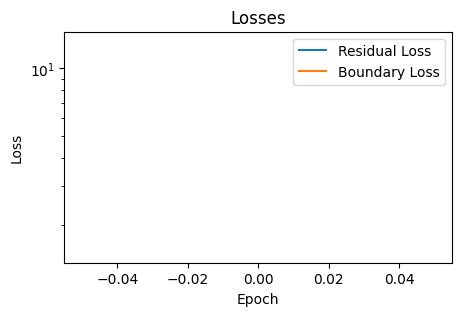

Epoch 1000, PDE loss: 0.3322897255420685, BC loss: 0.0059372130781412125


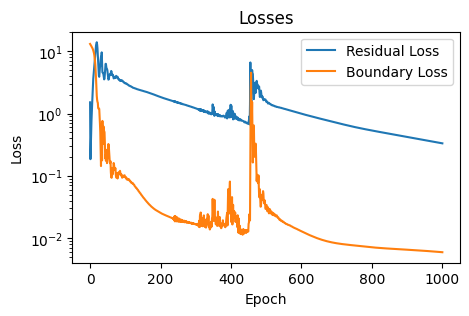

Epoch 2000, PDE loss: 0.07451211661100388, BC loss: 0.003840120043605566


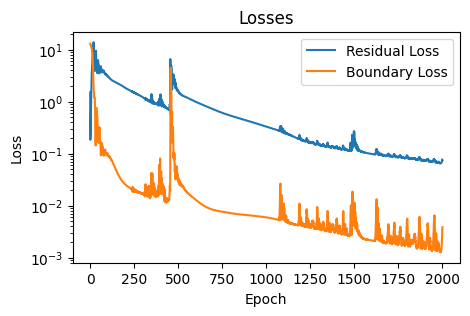

Epoch 3000, PDE loss: 0.14173483848571777, BC loss: 0.001988730626180768


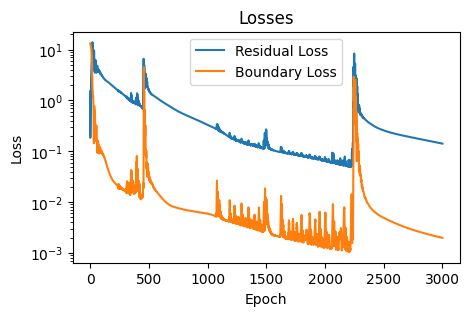

Epoch 4000, PDE loss: 0.0535273440182209, BC loss: 0.0010123963002115488


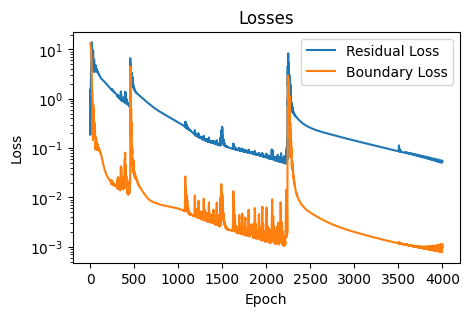

Epoch 5000, PDE loss: 0.01817108318209648, BC loss: 0.0007085095276124775


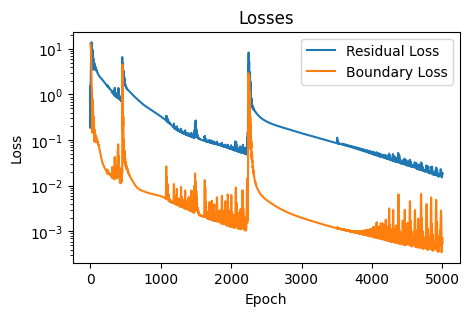

Epoch 6000, PDE loss: 0.005551778245717287, BC loss: 0.00020657549612224102


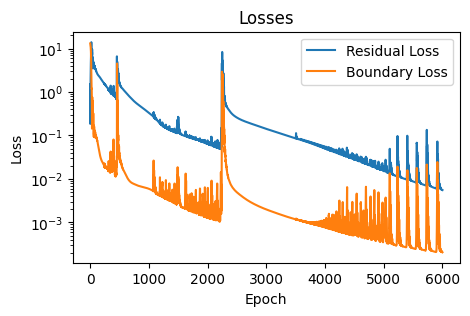

Epoch 7000, PDE loss: 0.02067391201853752, BC loss: 0.0005137345870025456


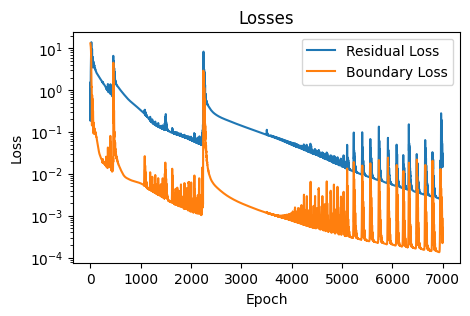

Epoch 8000, PDE loss: 0.09560069441795349, BC loss: 0.0016751022776588798


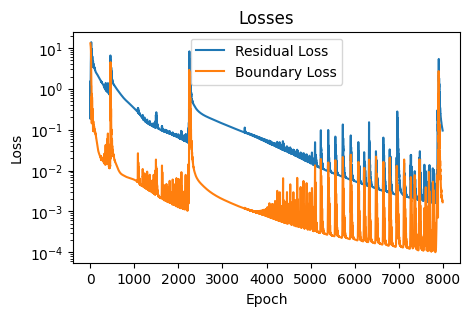

Epoch 9000, PDE loss: 0.006710027810186148, BC loss: 0.0004007380339317024


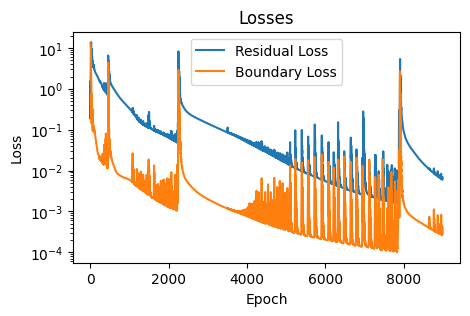

Epoch 10000, PDE loss: 0.00178446841891855, BC loss: 0.0001470419083489105


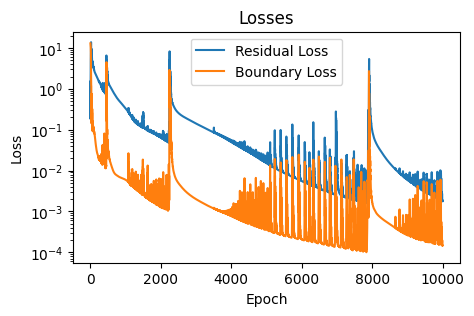

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim

class ParameterEncoder(nn.Module):
    def __init__(self):
        super(ParameterEncoder, self).__init__()
        self.layer1 = nn.Linear(3, 150)
        self.layer2 = nn.Linear(150, 150)
        self.layer3 = nn.Linear(150, 150)
        self.layer4 = nn.Linear(150, 50)
        self.tanh = nn.Tanh()

    def forward(self, m, mu, k):

        x = torch.cat([m, mu, k], dim=1)
        x = self.tanh(self.layer1(x))
        x = self.tanh(self.layer2(x))
        x = self.tanh(self.layer3(x))
        x = self.tanh(self.layer4(x))
        return x

class CoordinateEncoder(nn.Module):
    def __init__(self):
        super(CoordinateEncoder, self).__init__()
        self.layer1 = nn.Linear(3, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 50)
        self.tanh = nn.Tanh()

    def forward(self, t, y0, v0):

        x = torch.cat([t, y0, v0], dim=1)
        x = self.tanh(self.layer1(x))
        x = self.tanh(self.layer2(x))
        x = self.tanh(self.layer3(x))
        return x

class P2INN_full_all(nn.Module):
    def __init__(self):
        super(P2INN_full_all, self).__init__()
        
        self.encoder_p = ParameterEncoder()
        self.encoder_c = CoordinateEncoder()

        self.tanh = nn.Tanh()
        self.relu = nn.ReLU(inplace=True)

        self.dec_layer1 = nn.Linear(100, 50)
        self.dec_layer2 = nn.Linear(50, 50)
        self.dec_layer3 = nn.Linear(50, 50)
        self.dec_layer4 = nn.Linear(50, 50)
        self.dec_layer5 = nn.Linear(50, 50)
        self.dec_layer6 = nn.Linear(50, 50)
        self.last_layer = nn.Linear(50, 1)

        self.modvec = nn.Linear(6, 50)  # 6 inputs: (m, mu, k, t, y0, v0)

    def forward(self, t, m, mu, k, y0, v0):
        h_param = self.encoder_p(m, mu, k)
        h_coord = self.encoder_c(t, y0, v0)

        z_vector = torch.cat([h_param, h_coord], dim=1)

        dec_emb1 = self.tanh(self.dec_layer1(z_vector))
        dec_emb2 = self.tanh(self.dec_layer2(dec_emb1))
        dec_emb3 = self.tanh(self.dec_layer3(dec_emb2) + dec_emb1)
        dec_emb4 = self.tanh(self.dec_layer4(dec_emb3) + dec_emb2)
        dec_emb5 = self.tanh(self.dec_layer5(dec_emb4) + dec_emb3)
        
        input_vector = torch.cat([m, mu, k, t, y0, v0], dim=1)
        hyper_shift = self.modvec(input_vector)

        dec_emb6 = self.tanh(self.dec_layer6(dec_emb5) + dec_emb4 + hyper_shift)
        pred = self.last_layer(dec_emb6)

        return pred

# Run training pipeline
torch.manual_seed(42)
t_coll, m_coll, mu_coll, k_coll, y0_coll, v0_coll, t0 = initialize_uniform_all()

P2INN_full_uniform_all_model = P2INN_full_all()
optimizer = optim.Adam(P2INN_full_uniform_all_model.parameters(), lr=0.001)
trainer = Trainer(P2INN_full_uniform_all_model, optimizer, epochs=10001)
trainer.train(t_coll, m_coll, mu_coll, k_coll, y0_coll, v0_coll, t0)


In [89]:
import itertools
m_mean, m_std = 1.0, 0.1
mu_mean, mu_std = 0.6, 0.1
k_mean, k_std = 5.0, 0.5
y0_mean, y0_std = -0.4, 0.1
v0_mean, v0_std = 3.0, 0.5
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 4 * m_std, 6)
mu_values = np.linspace(mu_mean - 2 * mu_std, mu_mean + 4 * mu_std, 6)
k_values = np.linspace(k_mean - 2 * k_std, k_mean + 4 * k_std, 6)
y0_values = np.linspace(y0_mean - 2 * y0_std, y0_mean + 4 * y0_std, 6)
v0_values = np.linspace(v0_mean - 2 * v0_std, v0_mean + 4 * v0_std, 6)


t_test = torch.linspace(0, 5, 100).view(-1, 1)
errors = []
combos = list(itertools.product(m_values, mu_values, k_values, y0_values, v0_values))

for combo in combos:
    m_val_combo, mu_val_combo, k_val_combo, y0_val_combo, v0_val_combo = combo
    # Create a test tensor for each parameter with length equal to t_test
    m_test = torch.tensor([m_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    mu_test = torch.tensor([mu_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    k_test = torch.tensor([k_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    y0_test = torch.tensor([y0_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    v0_test = torch.tensor([v0_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    
    # Get the PINN prediction
    y_pred = P2INN_full_uniform_all_model(t_test, m_test, mu_test, k_test, y0_test, v0_test)
    # Compute the exact solution using the provided function (convert t_test to numpy)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), 
                                         m=m_val_combo, mu=mu_val_combo, 
                                         k=k_val_combo, y0=y0_val_combo, 
                                         v0=v0_val_combo)
    # Compute the mean squared error for this combination
    mse = np.mean((y_pred.detach().numpy() - y_exact)**2)
    errors.append(mse)
    # print(f"Combination (m, mu, k, y0, v0)=({m_val_combo:.2f}, {mu_val_combo:.2f}, {k_val_combo:.2f}, {y0_val_combo:.2f}, {v0_val_combo:.2f}) -> MSE = {mse:.6f}")

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all combinations: {combined_mse:.6f}")


Combined Mean Squared Error over all combinations: 0.026892


## Adaptive sampling 

In [ ]:
def objective_function(mass, pinn_model):
    # Use your PINN to predict the minimum oscillator output for a given mass
    min_output = pinn_model.predict_minimum(mass)
    
    # Objective is the absolute distance from failure (-1.0)
    return np.abs(min_output + 1.0)

## PINN-FORM


Epoch 0: Performing MPP search...
   [MPP Search] Iter 0: u = -0.0100, G = 0.9117, loss = 83.1284
   [MPP Search] Iter 20: u = -0.0026, G = 0.9117, loss = 83.1283
   [MPP Search] Iter 40: u = -0.0021, G = 0.9117, loss = 83.1283
   [MPP Search] Iter 60: u = -0.0024, G = 0.9117, loss = 83.1283
   [MPP Search] Iter 80: u = -0.0025, G = 0.9117, loss = 83.1283
   [MPP Search] Found: standard space u = -0.0025, physical m = 0.9997, G = 0.9117
Epoch 0: PDE Loss = 0.0552, BC Loss = 9.2713, MPP Loss = 0.8313
           MPP: physical m = 0.9997, G = 0.9117


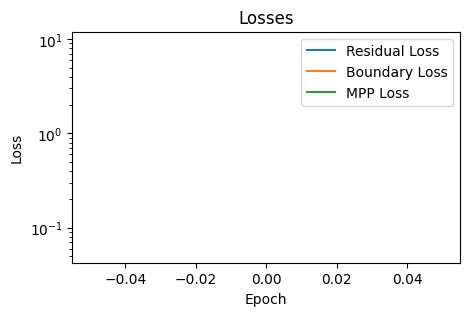

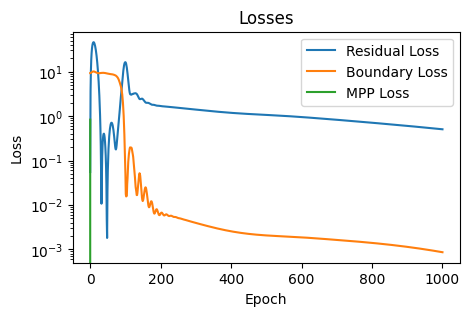

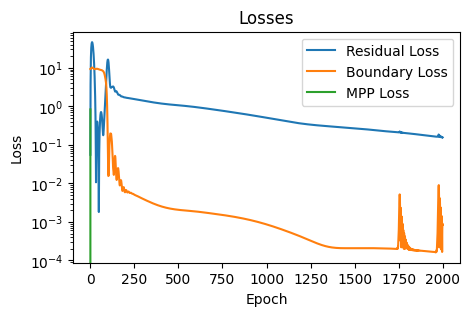

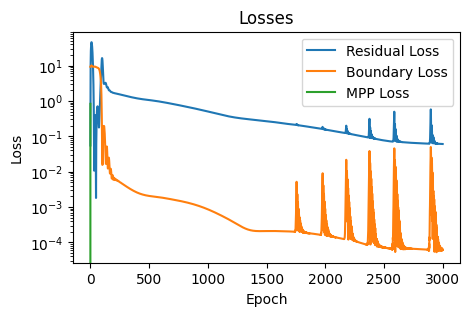


Epoch 4000: Performing MPP search...
   [MPP Search] Iter 0: u = 0.0100, G = 0.3456, loss = 11.9447
   [MPP Search] Iter 20: u = 0.2027, G = 0.3432, loss = 11.7949
   [MPP Search] Iter 40: u = 0.3568, G = 0.3416, loss = 11.7283
   [MPP Search] Iter 60: u = 0.4493, G = 0.3408, loss = 11.7113
   [MPP Search] Iter 80: u = 0.4864, G = 0.3405, loss = 11.7096
   [MPP Search] Found: standard space u = 0.4929, physical m = 1.0493, G = 0.3404
Epoch 4000: PDE Loss = 0.0487, BC Loss = 0.0000, MPP Loss = 0.1159
           MPP: physical m = 1.0493, G = 0.3404


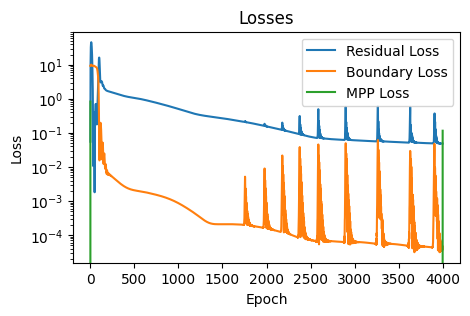

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Functions for transforming between physical space and standard normal space
def to_standard_normal(x, mean, std):
    return (x - mean) / std

def from_standard_normal(u, mean, std):
    return mean + std * u

# Define the PINN model
class PINN_gaussian_mass(nn.Module): 
    def __init__(self, hidden_size=20, hidden_layers=3, dropout_rate=0.05):
        super(PINN_gaussian_mass, self).__init__()
        input_dim = 6
        layers = [nn.Linear(input_dim, hidden_size), nn.Tanh()]
        
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout_rate))
        
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, t, m, mu, k, y0, v0):
        N = t.shape[0]
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, m, mu_, k_, y0_, v0_], dim=1)
        return self.net(x) 

# Compute PDE loss
def pde_loss(model, t, m, mu, k, y0_val, v0_val):
    y = model(t, m, mu, k, y0_val, v0_val)
    y_t = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    y_tt = torch.autograd.grad(y_t, t, grad_outputs=torch.ones_like(y_t), create_graph=True)[0]
    residual = m * y_tt + mu * y_t + k * y
    return torch.mean(residual**2)

# Compute boundary loss
def boundary_loss(model, t0, m, mu, k, y0, v0):
    y_pred = model(t0, m, mu, k, y0, v0)
    y_t = torch.autograd.grad(y_pred, t0, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    return torch.mean((y_pred - y0)**2 + (y_t - v0)**2)

def plot_loss(epoch, losses_dict):
    plt.figure(figsize=(5, 3))
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epoch, loss_values, label=loss_name)
    plt.yscale('log')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# ----- MPP Search Functions -----
def limit_state(model, u, mu, k, y0, v0, m_mean, m_std, device='cpu'):
    """
    Compute the limit-state function G(u) = min_{t in [0,5]} y(t; m(u)) + 1.0,
    where m = m_mean + m_std * u and failure is defined when y < -1.0.
    """
    m_val = from_standard_normal(u, m_mean, m_std)
    # Evaluate the model at a grid of time points in [0,5]
    t_vals = torch.linspace(0, 5, 100, device=device).view(-1, 1)
    m_vals = m_val.expand_as(t_vals)
    mu_vals = mu.expand_as(t_vals)
    k_vals = k.expand_as(t_vals)
    y0_vals = y0.expand_as(t_vals)
    v0_vals = v0.expand_as(t_vals)
    y_vals = model(t_vals, m_vals, mu_vals, k_vals, y0_vals, v0_vals)
    # G = (min y) + 1.0; failure when y < -1.0 (i.e. G < 0)
    G = torch.min(y_vals) + 1.0
    return G

def find_mpp(model, mu, k, y0, v0, m_mean, m_std, device='cpu', penalty=100.0, n_iter=100, lr=0.01):
    """
    Find the Most Probable Point (MPP) in standard normal space by solving:
       minimize 0.5 * u^2   subject to   G(u)=0.
    Here we use a penalty formulation:
       L(u) = 0.5 * u^2 + penalty * G(u)^2.
    """
    u = torch.tensor([0.0], requires_grad=True, device=device)
    optimizer = torch.optim.Adam([u], lr=lr)
    for i in range(n_iter):
        optimizer.zero_grad()
        G = limit_state(model, u, mu, k, y0, v0, m_mean, m_std, device=device)
        loss = 0.5 * u.pow(2).sum() + penalty * G.pow(2)
        loss.backward()
        optimizer.step()
        if i % 20 == 0:
            print(f"   [MPP Search] Iter {i}: u = {u.item():.4f}, G = {G.item():.4f}, loss = {loss.item():.4f}")
    m_val = from_standard_normal(u, m_mean, m_std)
    print(f"   [MPP Search] Found: standard space u = {u.item():.4f}, physical m = {m_val.item():.4f}, G = {G.item():.4f}")
    return u.detach(), m_val.detach(), G.detach()
# ----- End MPP Search Functions -----

# Trainer class to manage training process and include periodic MPP search
class Trainer:
    def __init__(self, model, optimizer, epochs=4001):
        self.model = model
        self.optimizer = optimizer
        self.epochs = epochs
        self.losses = {"Residual Loss": [], "Boundary Loss": [], "MPP Loss": []}
        self.lambda_bc = 10.0  # weight for boundary loss
    
    def train(self, t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0, m_mean, m_std, device='cpu'):
        mpp_interval = 4000   # how often (in epochs) to perform the MPP search
        lambda_mpp = 10.0    # weight for the MPP loss term
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()
            loss_pde = pde_loss(self.model, t_coll, m_val, mu_val, k_val, y0_val, v0_val)
            loss_bc = boundary_loss(self.model, t0, m_val, mu_val, k_val, y0_val, v0_val)
            loss_total = loss_pde + self.lambda_bc * loss_bc
            
            # Every 'mpp_interval' epochs, perform the MPP search and add its loss
            if epoch % mpp_interval == 0:
                print(f"\nEpoch {epoch}: Performing MPP search...")
                _, m_mpp, G_mpp = find_mpp(self.model, mu_val, k_val, y0_val, v0_val, m_mean, m_std, 
                                           device=device, n_iter=100, lr=0.01)
                loss_mpp = G_mpp.pow(2)
                loss_total = loss_total + lambda_mpp * loss_mpp
                self.losses["MPP Loss"].append(loss_mpp.item())
                print(f"Epoch {epoch}: PDE Loss = {loss_pde.item():.4f}, BC Loss = {loss_bc.item():.4f}, MPP Loss = {loss_mpp.item():.4f}")
                print(f"           MPP: physical m = {m_mpp.item():.4f}, G = {G_mpp.item():.4f}")
            else:
                self.losses["MPP Loss"].append(0.0)
            
            loss_total.backward()
            self.optimizer.step()
            
            self.losses["Residual Loss"].append(loss_pde.item())
            self.losses["Boundary Loss"].append(loss_bc.item())
            
            if epoch % 1000 == 0:
                plot_loss(range(epoch + 1), self.losses)

# Initialize training parameters
def initialize_gaussian_mass():
    N = 500
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = 1.0, 0.1
    # Sample m in physical space: later we will use transformation to standard normal in the MPP search.
    m_coll = m_mean + m_std * torch.randn((N, 1))
    m_coll.requires_grad_(True)
    mu, k, y0, v0 = 0.6, 5.0, -0.4, 3.0
    mu_val = torch.tensor([[mu]], requires_grad=True)
    k_val = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)
    return t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0, m_mean, m_std

# Run training pipeline with integrated MPP search
set_seed()
t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0, m_mean, m_std = initialize_gaussian_mass()
gaussian_mass_model = PINN_gaussian_mass(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(gaussian_mass_model.parameters(), lr=0.01)
trainer = Trainer(gaussian_mass_model, optimizer)
device = torch.device('cpu')
trainer.train(t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0, m_mean, m_std, device=device)
